# Satellite imagery access and analysis in Python & Jupyter notebooks


## Access, preprocess, analyse and visualize satellite images in Jupyter notebooks with Python.

The vast amount of satellite imagery collected every day across the globe is huge. In this tutorial, we will learn how to access satellite images, analyze and visualize them right in Jupyter notebooks with python. Satellite images are pixel wised data just like any other types of images you have used. In Geography and Remote sensing terminology, this is called Rasters. Raster images mainly consist of satellite images, Lidar data as well as Georeferenced maps. As we will see, rasters consist of a matrix of cells and row and each cell holds information about the location, such as elevation, temperature and vegetation.


In this tutorial, we will cover the following:
* Querry, retrieve and download satellite images directly with Python in Jupyter notebook.
* Read and Write Raster images in Python.
* Create RGB and NDVI images from Sentinel 2 Bands

### Accessing data
In this tutorial, we will use Sentinel 2 data. There are many options to access Sentinel 2 images and most of them will require you to access through website interaction whether directly via a downloading service utility or via the cloud. However, since we are using Jupyter notebook, we will access them right here using, sentinelsat a python library which makes searching, retrieving and downloading Sentinel satellite images easy. So let us start installing sentinelsat through pip.

In [1]:
!pip install sentinelsat
!pip install rasterio
!pip install folium
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
#!pip install git+git://github.com/geopandas/geopandas.git
!pip install geopandas
!pip install descartes 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 5.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 475 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 

In [2]:
import folium
import os
import numpy as np

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import fiona

Before we are able to use sentinelsat, we need to register a username in [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and note down your username and password and paste them here inside the code.

In [3]:
import getpass

user = 'lopslucas_' 

password = getpass.getpass("Enter password, please: ")
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

Enter password, please: ········


You are all set to use sentinelsat and download Sentinel Satellite images. In this tutorial, we will use data from Roma city, Italy. In the southern part of Roma, there is a natural reserve called Castel Porziano which we will use as a boundary to clip from the whole satellite image tile. 
I have the boundary of the natural reserve as Shapefile and we will read it with Geopandas and visualize it with Folium python library.

In [7]:
# Lendo shapes geométricos dos municípios de RO
geom_munic_ro = gpd.read_file('./malha-geometrica-municipios-ro/11MUE250GC_SIR.shp')
geom_munic_ro.head()

ID CD_GEOCODM             NM_MUNICIP  \
0   1    1100015  ALTA FLORESTA D'OESTE   
1   2    1100023              ARIQUEMES   
2   3    1100031                 CABIXI   
3   4    1100049                 CACOAL   
4   5    1100056             CEREJEIRAS   

                                            geometry  
0  POLYGON ((-62.24620 -11.90149, -62.24398 -11.9...  
1  POLYGON ((-63.13712 -9.78413, -63.09013 -9.782...  
2  POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...  
3  POLYGON ((-61.42679 -11.11376, -61.42900 -10.9...  
4  POLYGON ((-61.41347 -13.23417, -61.41505 -13.2...

In [8]:
# Selecionando o município Presidente Médici
geom_munic_ro[geom_munic_ro['NM_MUNICIP'] == 'PRESIDENTE MÉDICI']

ID CD_GEOCODM         NM_MUNICIP  \
17  18    1100254  PRESIDENTE MÉDICI   

                                             geometry  
17  POLYGON ((-61.74774 -10.98654, -61.63200 -10.9...

In [9]:
# Salvando dados do município
n_munic = geom_munic_ro[geom_munic_ro['NM_MUNICIP'] == 'PRESIDENTE MÉDICI']
centroid = n_munic['geometry'].centroid

C:\Users\lucas\AppData\Local\Temp/ipykernel_37460/3429366372.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = n_munic['geometry'].centroid


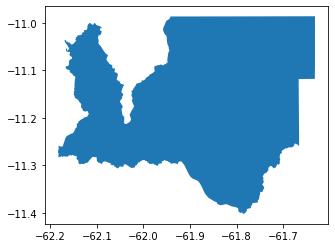

In [10]:
# Visualizando mapa do Município
n_munic.plot()
plt.show()

Visualizando mapa do município

In [11]:
m = folium.Map( (centroid.y, centroid.x), zoom_start=10)

folium.GeoJson(n_munic).add_to(m)
m

With the above code, we have read natural reserve shapefile in Geopandas and called it nReserve, then later created an empty base map in Folium centred around coordinates in the area, we call this m. Finally, we can add the Geopandas data to the base map we have created to visualize the Natural Reserve boundary we are interested in. Below you can see the map.

One last step before we can search and download sentinel 2 images is to create a footprint from the nReservegeometry. Here we will use Shapely Python library since our data is in Shapefiles and read it already as Geopandas GeodataFrame. (Note that if you have Geojson data, Sentinelsat provides a handy way to convert your data into a proper format in the query).

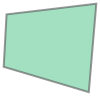

In [12]:
footprint = None
for i in n_munic['geometry'].simplify(1):
    footprint = i
    
footprint

Now we can run a query on the apiwe have created above. There are different ways you can construct your query here depending on your use case. In this example, we will create a query for Sentinel 2 images Level 2A with cloud coverage between 0 and 10 that fall or intersect with the footprint (Area of study). For the time period, we are interested in Sentinel Level 2A satellite images taken between '20190601' and '20190626' (For reference on valid search queries please refer to[ scihub](https://scihub.copernicus.eu/twiki/do/view/SciHubUserGuide/FullTextSearch?redirectedfrom=SciHubUserGuide.3FullTextSearch)).

In [28]:
products = api.query(footprint,
                     date = ('20210701', '20221101'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,5))

Querying products:  85%|########5 | 100/117 [00:00<?, ?product/s]

We get a dictionary of all products available in this period with the query specification. In this case, we receive only 6 images taken but you can tweak the query for your use case example expanding the time period or increasing the cloud coverage percentage.  


In [29]:
len(products)

117

From here we can create a GeodataFrame or Dataframe from the product dictionary and sort them according to cloud coverage percentage.

In [30]:
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

title  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  S2B_MSIL2A_20220731T141719_N0400_R010_T20LNN_2...   
8f02229a-c426-405d-9c8e-058f93072d7c  S2A_MSIL2A_20220517T141741_N0400_R010_T20LNN_2...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  S2B_MSIL2A_20220830T141709_N0400_R010_T20LNN_2...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  S2A_MSIL2A_20220507T141741_N0400_R010_T20LNN_2...   
abc6791d-0357-46f0-8688-2554987f6b63  S2B_MSIL2A_20220813T142719_N0400_R053_T20LPN_2...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  S2A_MSIL2A_20220914T141721_N0400_R010_T20LNN_2...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  S2A_MSIL2A_20220726T141751_N0400_R010_T20LPN_2...   
ec50dfb5-7a6e-4796-b43d-ffb8df90ec97  S2A_MSIL2A_20220226T141741_N0400_R010_T20LNN_2...   
46a4cb98-1b7b-4be4-a545-77f3d3575684  S2A_MSIL2A_20220626T141721_N0400_R010_T20LPN_2...   
5cb94005-40e4-4b66-a667-8a879d404071  S2B_MSIL2A_20220115T142729_N0301_R053_T20LNN_2...   

                                                                                   link  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
8f02229a-c426-405d-9c8e-058f93072d7c  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
abc6791d-0357-46f0-8688-2554987f6b63  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ec50dfb5-7a6e-4796-b43d-ffb8df90ec97  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
46a4cb98-1b7b-4be4-a545-77f3d3575684  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
5cb94005-40e4-4b66-a667-8a879d404071  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
8f02229a-c426-405d-9c8e-058f93072d7c  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
abc6791d-0357-46f0-8688-2554987f6b63  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ec50dfb5-7a6e-4796-b43d-ffb8df90ec97  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
46a4cb98-1b7b-4be4-a545-77f3d3575684  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
5cb94005-40e4-4b66-a667-8a879d404071  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
8f02229a-c426-405d-9c8e-058f93072d7c  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
abc6791d-0357-46f0-8688-2554987f6b63  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  https://scihub.copernicus.eu/dhus/oda

In [31]:
products_gdf_sorted.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'generationdate', 'beginposition', 'endposition', 'ingestiondate',
       'orbitnumber', 'relativeorbitnumber', 'illuminationazimuthangle',
       'illuminationzenithangle', 'vegetationpercentage',
       'notvegetatedpercentage', 'waterpercentage', 'unclassifiedpercentage',
       'mediumprobacloudspercentage', 'highprobacloudspercentage',
       'snowicepercentage', 'cloudcoverpercentage', 'level1cpdiidentifier',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'datastripidentifier',
       'granuleidentifier', 'identifier', 'uuid', 'geometry'],
      dtype='object')

Let us say we are interested in the first satellite image since this has the least cloud coverage of all available images. we can simply call download and provide the product name (Note that you can download all images at once with api.download_all() function).

In [32]:
# Dimensões dos metadados do satélite
products_gdf_sorted.shape

(117, 41)

In [33]:
products_gdf_sorted

title  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  S2B_MSIL2A_20220731T141719_N0400_R010_T20LNN_2...   
8f02229a-c426-405d-9c8e-058f93072d7c  S2A_MSIL2A_20220517T141741_N0400_R010_T20LNN_2...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  S2B_MSIL2A_20220830T141709_N0400_R010_T20LNN_2...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  S2A_MSIL2A_20220507T141741_N0400_R010_T20LNN_2...   
abc6791d-0357-46f0-8688-2554987f6b63  S2B_MSIL2A_20220813T142719_N0400_R053_T20LPN_2...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  S2A_MSIL2A_20220914T141721_N0400_R010_T20LNN_2...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  S2A_MSIL2A_20220726T141751_N0400_R010_T20LPN_2...   
ec50dfb5-7a6e-4796-b43d-ffb8df90ec97  S2A_MSIL2A_20220226T141741_N0400_R010_T20LNN_2...   
46a4cb98-1b7b-4be4-a545-77f3d3575684  S2A_MSIL2A_20220626T141721_N0400_R010_T20LPN_2...   
5cb94005-40e4-4b66-a667-8a879d404071  S2B_MSIL2A_20220115T142729_N0301_R053_T20LNN_2...   

                                                                                   link  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
8f02229a-c426-405d-9c8e-058f93072d7c  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
abc6791d-0357-46f0-8688-2554987f6b63  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ec50dfb5-7a6e-4796-b43d-ffb8df90ec97  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
46a4cb98-1b7b-4be4-a545-77f3d3575684  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
5cb94005-40e4-4b66-a667-8a879d404071  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
8f02229a-c426-405d-9c8e-058f93072d7c  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
abc6791d-0357-46f0-8688-2554987f6b63  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ec50dfb5-7a6e-4796-b43d-ffb8df90ec97  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
46a4cb98-1b7b-4be4-a545-77f3d3575684  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
5cb94005-40e4-4b66-a667-8a879d404071  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
8f02229a-c426-405d-9c8e-058f93072d7c  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
abc6791d-0357-46f0-8688-2554987f6b63  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  https://scihub.copernicus.eu/dhus/oda

<AxesSubplot:ylabel='Frequency'>

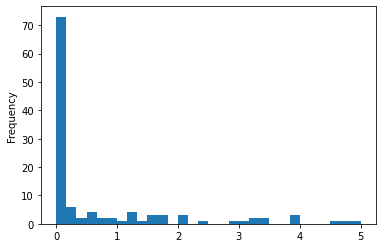

In [34]:
# Distribuição da cobertura de nuvens
products_gdf_sorted['cloudcoverpercentage'].plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

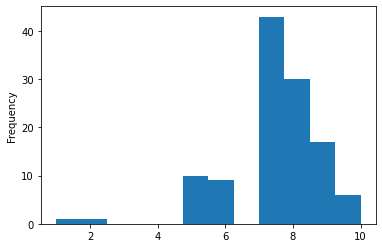

In [38]:
products_gdf_sorted['generationdate'].dt.month.plot(kind='hist', bins=12)

In [43]:
sorted(products_gdf_sorted['generationdate'].dt.month.unique())

[1, 2, 5, 6, 7, 8, 9, 10]

In [52]:
products_gdf_sorted.groupby(products_gdf_sorted['generationdate'].dt.month)['cloudcoverpercentage'].count()

generationdate
1      1
2      1
5     10
6      9
7     43
8     30
9     17
10     6
Name: cloudcoverpercentage, dtype: int64

In [46]:
# Amostras com menor cobertura de nuvens para cada um dos meses do ano (dos dados gerados)
samples = products_gdf_sorted.groupby(products_gdf_sorted['generationdate'].dt.month)['cloudcoverpercentage'].idxmin()
samples

generationdate
1     5cb94005-40e4-4b66-a667-8a879d404071
2     ec50dfb5-7a6e-4796-b43d-ffb8df90ec97
5     8f02229a-c426-405d-9c8e-058f93072d7c
6     878a8551-b5b1-4dcb-a783-235b36990eac
7     bfd98039-e3f2-4337-8fc6-ee2bf69c91a6
8     a974238e-b74e-415c-aaa0-6cf2d703ea4a
9     4e1c6572-e3a0-4a96-bb83-8b3cef714acd
10    bfba5f53-c418-433f-88f9-cb7f9521bc9b
Name: cloudcoverpercentage, dtype: object

In [51]:
products_gdf_sorted

title  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  S2B_MSIL2A_20220731T141719_N0400_R010_T20LNN_2...   
8f02229a-c426-405d-9c8e-058f93072d7c  S2A_MSIL2A_20220517T141741_N0400_R010_T20LNN_2...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  S2B_MSIL2A_20220830T141709_N0400_R010_T20LNN_2...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  S2A_MSIL2A_20220507T141741_N0400_R010_T20LNN_2...   
abc6791d-0357-46f0-8688-2554987f6b63  S2B_MSIL2A_20220813T142719_N0400_R053_T20LPN_2...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  S2A_MSIL2A_20220914T141721_N0400_R010_T20LNN_2...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  S2A_MSIL2A_20220726T141751_N0400_R010_T20LPN_2...   
ec50dfb5-7a6e-4796-b43d-ffb8df90ec97  S2A_MSIL2A_20220226T141741_N0400_R010_T20LNN_2...   
46a4cb98-1b7b-4be4-a545-77f3d3575684  S2A_MSIL2A_20220626T141721_N0400_R010_T20LPN_2...   
5cb94005-40e4-4b66-a667-8a879d404071  S2B_MSIL2A_20220115T142729_N0301_R053_T20LNN_2...   

                                                                                   link  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
8f02229a-c426-405d-9c8e-058f93072d7c  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
abc6791d-0357-46f0-8688-2554987f6b63  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ec50dfb5-7a6e-4796-b43d-ffb8df90ec97  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
46a4cb98-1b7b-4be4-a545-77f3d3575684  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
5cb94005-40e4-4b66-a667-8a879d404071  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
8f02229a-c426-405d-9c8e-058f93072d7c  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
abc6791d-0357-46f0-8688-2554987f6b63  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ec50dfb5-7a6e-4796-b43d-ffb8df90ec97  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
46a4cb98-1b7b-4be4-a545-77f3d3575684  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
5cb94005-40e4-4b66-a667-8a879d404071  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
bfd98039-e3f2-4337-8fc6-ee2bf69c91a6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
8f02229a-c426-405d-9c8e-058f93072d7c  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
a974238e-b74e-415c-aaa0-6cf2d703ea4a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
ce43a93a-bc8f-499c-852d-43c45b2dd6be  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
abc6791d-0357-46f0-8688-2554987f6b63  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
...                                                                                 ...   
39729b94-3c9b-4da4-8c70-4f4705c3a550  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
fcf28b59-ca1f-440c-97e4-0d028aa81792  https://scihub.copernicus.eu/dhus/oda

In [48]:
for i in samples:
    api.download(i)

LTATriggered: Product 5cb94005-40e4-4b66-a667-8a879d404071 is not online. Triggered retrieval from the Long Term Archive.

In [23]:
min_cloudcovered_sample = products_gdf_sorted['cloudcoverpercentage'].idxmin()
print(f"Amostra com menor percentual de cobertura de nuvens: '{min_cloudcovered_sample}'")
print(f"Percentual de cobertura de nuvens: {products_gdf_sorted['cloudcoverpercentage'].min():.3f}")

Amostra com menor percentual de cobertura de nuvens: '878a8551-b5b1-4dcb-a783-235b36990eac'
Percentual de cobertura de nuvens: 0.003


In [24]:
api.download('878a8551-b5b1-4dcb-a783-235b36990eac')

MD5 checksumming:   0%|          | 0.00/105M [00:00<?, ?B/s]

{'id': '878a8551-b5b1-4dcb-a783-235b36990eac',
 'title': 'S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823',
 'size': 105317538,
 'md5': '79ca9cf0925147adc41070c9814bb5f2',
 'date': datetime.datetime(2022, 6, 21, 14, 17, 19, 24000),
 'footprint': 'POLYGON((-62.174927 -11.847021894665437,-62.151337 -11.745668599460696,-62.117188 -11.597200525571518,-62.082977 -11.448723815073487,-62.048798 -11.300275853057864,-62.014557 -11.151850305024062,-61.994873 -11.066249926662687,-61.992157 -11.84669686849412,-62.174927 -11.847021894665437))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('878a8551-b5b1-4dcb-a783-235b36990eac')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2022, 6, 21, 19, 56, 14, 425000),
 'Ingestion Date': datetime.datetime(2022, 6, 21, 19, 55, 45, 998000),
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('878a8551-b5b1-4dcb-a783-235b36990eac')/Products('Quicklook')/$value",
 'path': 'S2B_MSIL2A_20220621T141719_N0

This will take a while (Sentinel 2 Satellite image tiles are about 1 GB). Once the download is finished, we can simply unzip it. In the next section, we will use the downloaded satellite images to process, analyze and visualize them.

## Exploring Satellite Imagery with Rasterio
Once we unzip the downloaded folder, we get many subfolders and it is sometimes hard to navigate through these folders. Sentinel-2 data is multispectral with 13 bands in the visible, near infrared and shortwave infrared spectrum. These bands come in a different spatial resolution ranging from 10 m to 60 m, thus images can be categorized as high-medium resolution. While there are other higher resolution satellites available(1m to 0.5 cm), Sentinel-2 data is free and has a high revisit time (5 days) which makes it an excellent option to study environmental challenges.

### Create RGB Image 
The true colour of satellite images is often displayed in a combination of red, green and blue band. Let us first read the data with Rasterio and create an RGB image from Bands 4, 3, and 2.

In [25]:
!unzip /content/S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.zip

Archive:  /content/S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.zip
   creating: S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.SAFE/
 extracting: S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.SAFE/INSPIRE.xml  
 extracting: S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.SAFE/MTD_MSIL2A.xml  
 extracting: S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.SAFE/manifest.safe  
   creating: S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.SAFE/HTML/
   creating: S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.SAFE/DATASTRIP/
   creating: S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.SAFE/rep_info/
   creating: S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.SAFE/GRANULE/
   creating: S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.SAFE/AUX_DATA/
 extracting: S2B_MSIL2A_20220621T141719_N0400_R010_T20LNN_20220621T164823.SAFE/HTML/banner_2.png  
 extracting:

In [ ]:
# Open Bands 4, 3 and 2 with Rasterio
R10 = 'S2B_MSIL2A_20190605T100039_N0212_R122_T33TTG_20190605T143319.SAFE/GRANULE/L2A_T33TTG_A011731_20190605T100530/IMG_DATA/R10m'

b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b3 = rio.open(R10+'/T33TTG_20190605T100039_B03_10m.jp2')
b2 = rio.open(R10+'/T33TTG_20190605T100039_B02_10m.jp2')

In [ ]:
b4.count, b4.width, b4.height

(1, 10980, 10980)

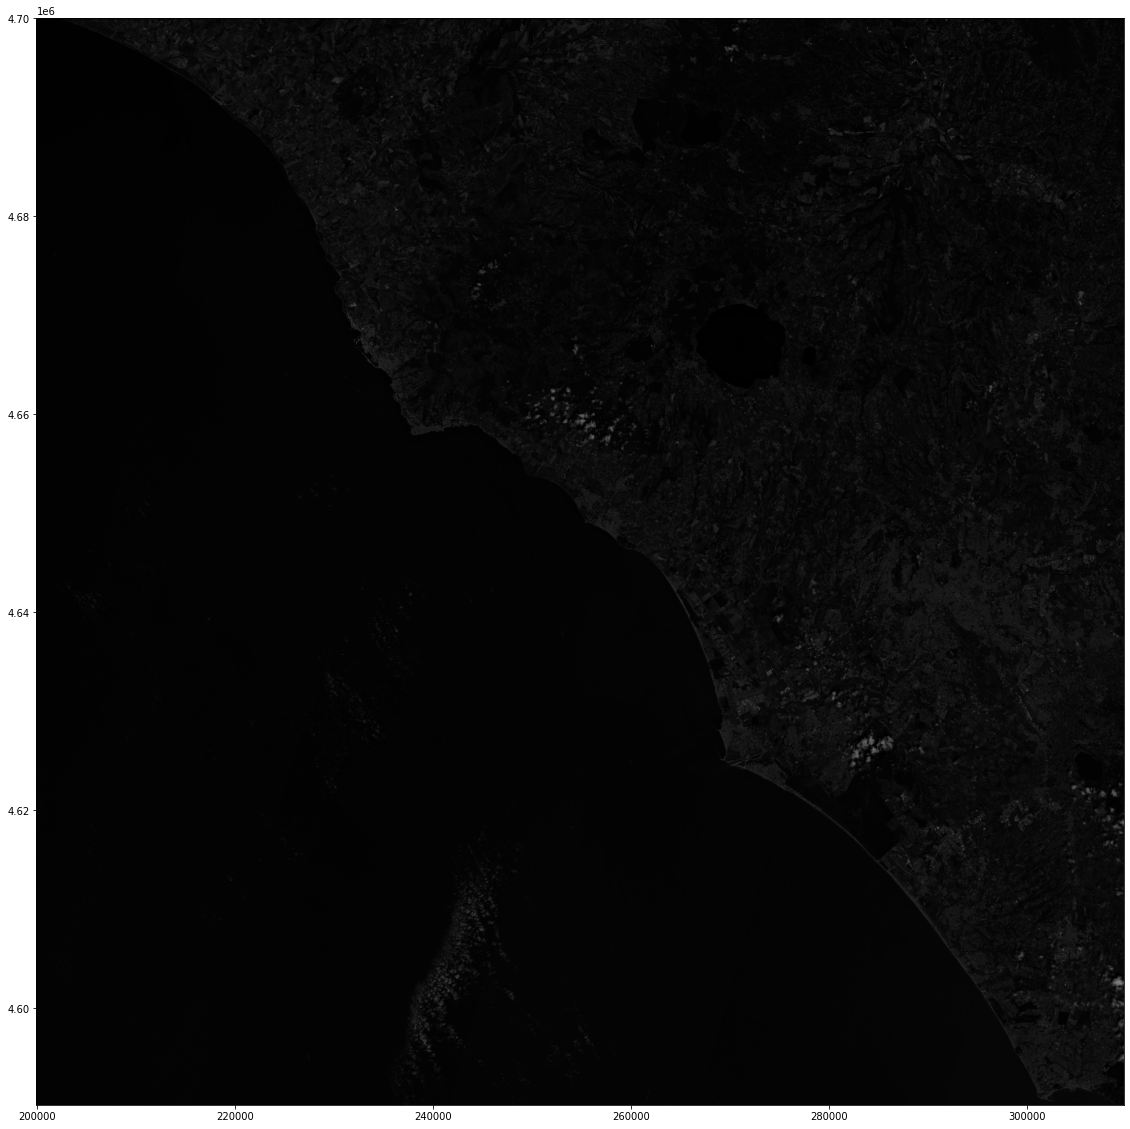

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 20))
show(b4, ax=ax, cmap='gray')
plt.show()

In [ ]:
with rio.open('RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

### Mask Satellite images

One important preprocessing task to clip or mask an area of study. Since this RGB image is large and huge you save both computing power and time to clip and use only the area of interest. We will clip the Natural reserve area from the RGB image.

In [ ]:
src = rio.open(r"RGB.tiff")
nReserve_proj = nReserve.to_crs({'init': 'epsg:32633'})

with rio.open("RGB.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
with rasterio.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Here, we first reproject our Natural reserve with the same projection as the RGB image. Next, we open the RGB image, get the metadata and mask with the projected boundary.

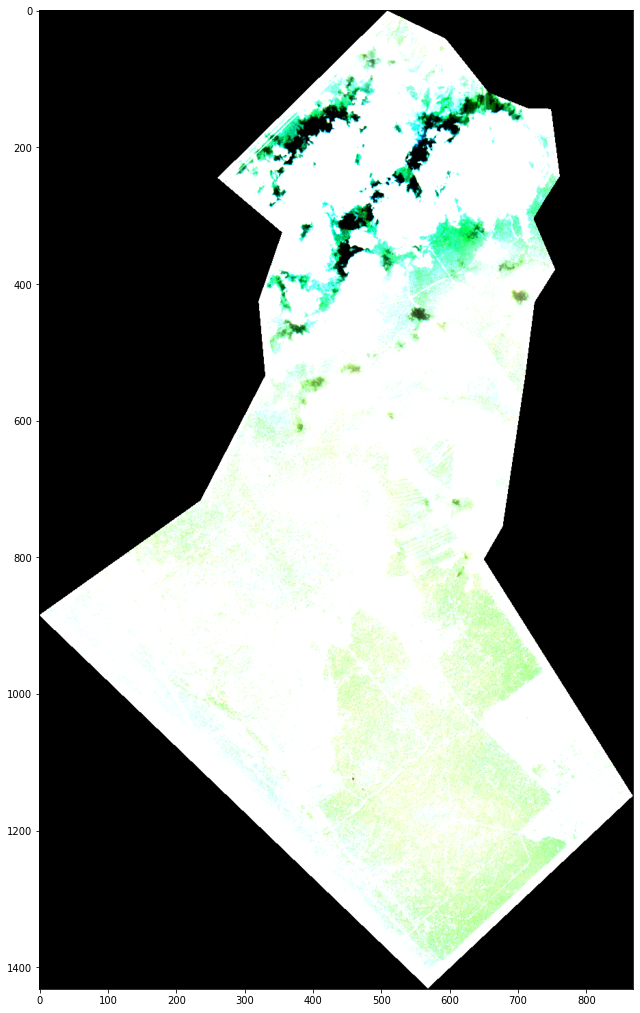

<function matplotlib.pyplot.show(*args, **kw)>

In [ ]:
msk = rio.open(r"RGB_masked.tif")
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show

### Create NDVI 
Calculating Normalized Difference Vegetation Index (NDVI) is an important indicator to assess the presence/absence of green vegetation from the satellite images. To calculate the NDVI, you need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for this band. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:
nir - red /(nir + red).

To carry out this in Rasterio we need first to read the 4th and 8th bands as arrays. We also need to make sure that the arrays are floats.

In [ ]:
b4 = rio.open(R10+'/T33TTG_20190605T100039_B04_10m.jp2')
b8 = rio.open(R10+'/T33TTG_20190605T100039_B08_10m.jp2')


In [ ]:
red = b4.read()
nir = b8.read()

In [ ]:
ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

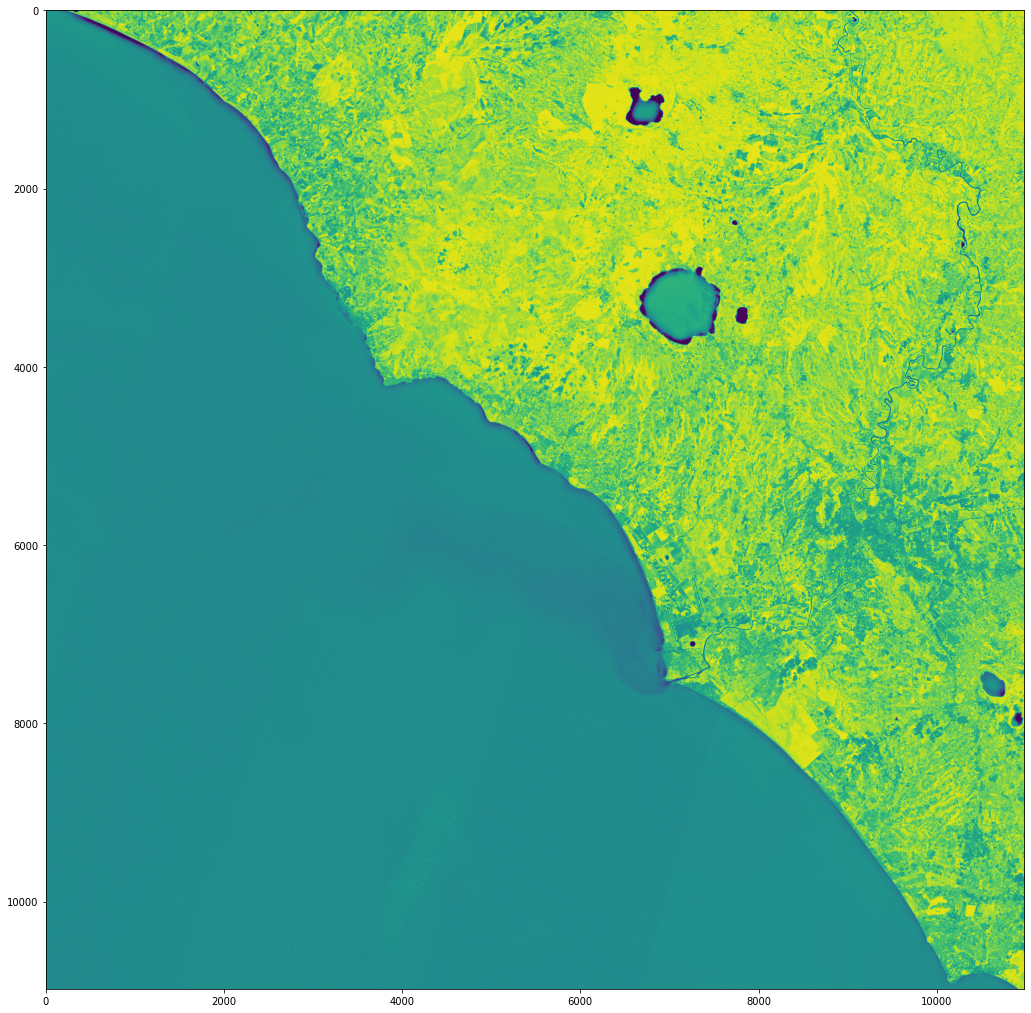

In [ ]:
fig, ax = plt.subplots(1, figsize=(18, 18))
show(ndvi)

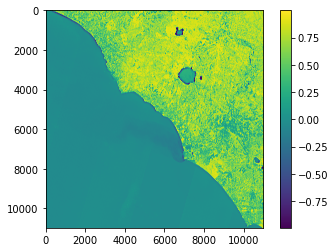

In [ ]:
plt.imshow(ndvi[0])
plt.colorbar()

In [ ]:
meta = b4.meta

meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

with rasterio.open('NDVI.tif', 'w', **meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

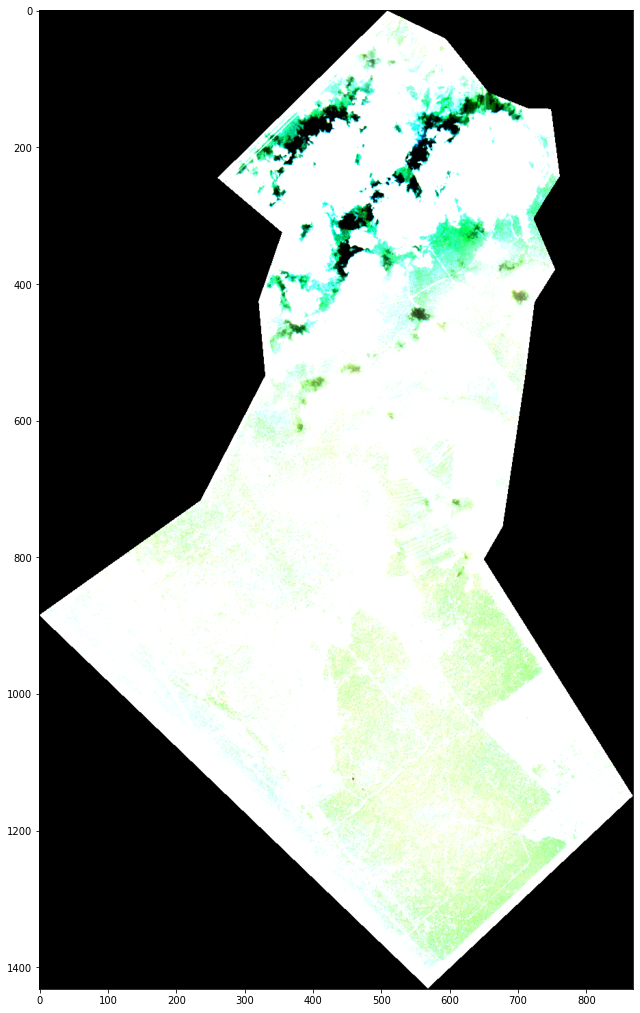

<function matplotlib.pyplot.show(*args, **kw)>

In [ ]:
fig, ax = plt.subplots(1, figsize=(18, 18))
show(msk.read([1,2,3]))
plt.show

# Conclusion
Accessing Sentinel 2 images with Python is made easy with sentinelsat. In this tutorial, we have covered how to construct a query and retrieve on information from available images as well as how to download Sentinel 2 images within Jupyter notebooks. We have also seen how to preprocess, create RGB and NDVI images and visualize raster images with Rasterio.